In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# ---------- Load Data ----------
full_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/bd_building_feat-dist_dem_ghs.gpkg"
output_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/mlp_files/MLP_bd_building_labeled_and_pseudo.gpkg"
labeled_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/bd_building_only_labeled.gpkg"
gdf_labeled = gpd.read_file(labeled_path)

# Drop unnecessary columns
drop_cols = ['fid', 'org_fid', 'building_category']
gdf_labeled = gdf_labeled.drop(columns=[c for c in drop_cols if c in gdf_labeled.columns], errors='ignore')

# Target and Features
target_col = 'binary_category'
X = gdf_labeled.drop(columns=[target_col, 'geometry'], errors='ignore')
y = gdf_labeled[target_col]

# ---------- Handle binary mask columns ----------
binary_mask_cols = ['pop_missing', 'built-s_missing', 'ntl_missing', 'urban_index_missing']
if 'In_landuse_a' in X.columns:
    X['In_landuse_a'] = X['In_landuse_a'].astype(int)
for col in binary_mask_cols:
    if col in X.columns:
        X[col] = X[col].astype(int)

# ---------- Separate numeric and categorical ----------
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

# ---------- Fill and encode ----------
for col in categorical_cols:
    X[col] = X[col].fillna('unknown').astype(str)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ---------- Train-Test Split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ---------- Preprocessing Pipelines ----------
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# ---------- SMOTE + MLP Pipeline ----------
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', MLPClassifier(random_state=42, max_iter=300))
])

# ---------- Grid Search ----------
param_grid = {
    'classifier__hidden_layer_sizes': [(100,), (100, 50)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__alpha': [0.0001, 0.001],
    'classifier__learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# ---------- Train ----------
print("Training MLP model with GridSearchCV and OneHotEncoding...")
grid_search.fit(X_train, y_train)
print(f"\n✅ Best Parameters: {grid_search.best_params_}")
print(f"✅ Best F1-score (CV): {grid_search.best_score_:.4f}")

# ---------- Evaluate ----------
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n--- Classification Report (on Test Set) ---")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))

# Bundle and save the model
model_bundle = {
    'model': best_model,
    'label_encoder': le,
    'features': X.columns.tolist()
}

model_save_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/mlp_files/NOpsudo_mlp_model.joblib"
joblib.dump(model_bundle, model_save_path)

print(f"✅ MLP Model saved to: {model_save_path}")


Training MLP model with GridSearchCV and OneHotEncoding...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

✅ Best Parameters: {'classifier__activation': 'relu', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate': 'constant'}
✅ Best F1-score (CV): 0.9568

--- Classification Report (on Test Set) ---
                 precision    recall  f1-score   support

non_residential       0.76      0.82      0.79      3084
    residential       0.96      0.95      0.95     14872

       accuracy                           0.93     17956
      macro avg       0.86      0.88      0.87     17956
   weighted avg       0.93      0.93      0.93     17956

--- Confusion Matrix ---
[[ 2534   550]
 [  790 14082]]
✅ MLP Model saved to: D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/mlp_files/mlp_model.joblib


In [2]:
import geopandas as gpd
import numpy as np
import fiona
import joblib
import pandas as pd
import heapq

# ------------------------------
# Settings and file paths
# ------------------------------
model_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/mlp_files/mlp_model.joblib"
full_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/bd_building_feat-dist_dem_ghs.gpkg"
labeled_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/bd_building_only_labeled.gpkg"
output_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/mlp_files/MLP_bd_building_labeled_and_pseudo.gpkg"
layer_name = 'fea-dist_dem_ghs'
target_col = 'binary_category'
drop_cols = ['fid', 'org_fid', 'building_category']
chunk_size = 200_000  # smaller chunk for MLP
TARGET_RES_COUNT = 600_000
TARGET_NONRES_COUNT = 200_000

# ------------------------------
# Load trained MLP pipeline
# ------------------------------
print("Loading MLP pipeline and label encoder...")
model_bundle = joblib.load(model_path)
best_model = model_bundle['model']
le = model_bundle['label_encoder']

# ------------------------------
# Tie-safe heap for top-N selection
# ------------------------------
res_heap = []
nonres_heap = []
counter = 0  # unique tiebreaker to keep determinism

def add_to_heap_tiesafe(heap, conf, row_dict, max_size):
    global counter
    entry = (float(conf), counter, row_dict)
    counter += 1
    if len(heap) < max_size:
        heapq.heappush(heap, entry)
        return
    min_conf = heap[0][0]
    if conf > min_conf:
        heapq.heapreplace(heap, entry)
    elif conf == min_conf:
        heapq.heappush(heap, entry)

# ------------------------------
# Process dataset in chunks
# ------------------------------
print("Starting chunked pseudo-labeling with streaming top-N selection...")
with fiona.Env():
    with fiona.open(full_path, layer=layer_name) as src:
        total = len(src)
        for i in range(0, total, chunk_size):
            start = i
            stop = min(i + chunk_size, total)
            print(f"Processing rows {start} to {stop}...")

            # Load chunk
            gdf_chunk = gpd.read_file(full_path, rows=slice(start, stop), layer=layer_name)
            gdf_chunk = gdf_chunk.drop(columns=[c for c in drop_cols if c in gdf_chunk.columns], errors='ignore')

            # Keep only unlabeled rows
            mask_unlabeled = gdf_chunk[target_col].isna()
            if not mask_unlabeled.any():
                continue
            gdf_unlabeled = gdf_chunk[mask_unlabeled].copy()

            # Prepare feature matrix (drop target + geometry)
            X = gdf_unlabeled.drop(columns=['geometry', target_col], errors='ignore')

            # Predict probabilities using the **full pipeline** (preprocessing included)
            probs = best_model.predict_proba(X)
            max_conf = np.max(probs, axis=1)
            pred_classes = np.argmax(probs, axis=1)
            pseudo_labels = le.inverse_transform(pred_classes)

            # Attach predictions & confidence
            gdf_unlabeled[target_col] = pseudo_labels
            gdf_unlabeled['pseudo_labeled'] = 1
            gdf_unlabeled['confidence'] = max_conf

            # Add top-N per class to heaps
            cols_to_keep = list(gdf_unlabeled.columns)
            for local_idx in range(len(gdf_unlabeled)):
                row_series = gdf_unlabeled.iloc[local_idx]
                conf = float(row_series['confidence'])
                label = row_series[target_col]
                row_dict = {c: row_series[c] for c in cols_to_keep}
                if label == 'residential':
                    add_to_heap_tiesafe(res_heap, conf, row_dict, TARGET_RES_COUNT)
                elif label == 'non_residential':
                    add_to_heap_tiesafe(nonres_heap, conf, row_dict, TARGET_NONRES_COUNT)

# ------------------------------
# Build final pseudo GeoDataFrame
# ------------------------------
print("Building final pseudo dataset from heaps...")
res_rows = [entry[2] for entry in res_heap]
nonres_rows = [entry[2] for entry in nonres_heap]

res_gdf = gpd.GeoDataFrame(pd.DataFrame(res_rows), geometry='geometry', crs=gdf_chunk.crs) if res_rows else gpd.GeoDataFrame(columns=gdf_chunk.columns)
nonres_gdf = gpd.GeoDataFrame(pd.DataFrame(nonres_rows), geometry='geometry', crs=gdf_chunk.crs) if nonres_rows else gpd.GeoDataFrame(columns=gdf_chunk.columns)

final_pseudo = pd.concat([res_gdf, nonres_gdf], ignore_index=True)
final_pseudo = gpd.GeoDataFrame(final_pseudo, geometry='geometry', crs=gdf_chunk.crs)

print(f"✅ Final pseudo dataset size: {len(final_pseudo)}")
print(f"   Residential: {len(res_gdf)}, Non-residential: {len(nonres_gdf)}")

# ------------------------------
# Combine with labeled dataset and save
# ------------------------------
print("Combining with original labeled dataset and saving...")
gdf_labeled = gpd.read_file(labeled_path)
gdf_labeled = gdf_labeled[gdf_labeled[target_col].notna()].copy()
gdf_labeled['pseudo_labeled'] = 0
gdf_labeled['confidence'] = 1.0

gdf_combined = pd.concat([gdf_labeled, final_pseudo], ignore_index=True)
gdf_combined = gpd.GeoDataFrame(gdf_combined, geometry='geometry', crs=gdf_labeled.crs)

print(f"Saving to {output_path} ...")
gdf_combined.to_file(output_path, driver="GPKG")
print("✅ Done.")


Loading MLP pipeline and label encoder...
Starting chunked pseudo-labeling with streaming top-N selection...
Processing rows 0 to 200000...
Processing rows 200000 to 400000...
Processing rows 400000 to 600000...
Processing rows 600000 to 800000...
Processing rows 800000 to 1000000...
Processing rows 1000000 to 1200000...
Processing rows 1200000 to 1400000...
Processing rows 1400000 to 1600000...
Processing rows 1600000 to 1800000...
Processing rows 1800000 to 2000000...
Processing rows 2000000 to 2200000...
Processing rows 2200000 to 2400000...
Processing rows 2400000 to 2600000...
Processing rows 2600000 to 2800000...
Processing rows 2800000 to 3000000...
Processing rows 3000000 to 3200000...
Processing rows 3200000 to 3400000...
Processing rows 3400000 to 3600000...
Processing rows 3600000 to 3800000...
Processing rows 3800000 to 4000000...
Processing rows 4000000 to 4200000...
Processing rows 4200000 to 4400000...
Processing rows 4400000 to 4600000...
Processing rows 4600000 to 4800

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# ---------- Load Data ----------
pseudo_label_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/mlp_files/MLP_bd_building_labeled_and_pseudo.gpkg"
gdf_labeled = gpd.read_file(pseudo_label_path)

# ---------- Drop unnecessary columns ----------
drop_cols = ['fid', 'org_fid', 'building_category', 'pseudo_labeled', 'confidence']
gdf_labeled = gdf_labeled.drop(columns=[c for c in drop_cols if c in gdf_labeled.columns], errors='ignore')

# ---------- Define features and target ----------
target_col = 'binary_category'
X = gdf_labeled.drop(columns=[target_col, 'geometry'], errors='ignore')
y = gdf_labeled[target_col]

# ---------- Handle binary mask columns ----------
binary_mask_cols = ['pop_missing', 'built-s_missing', 'ntl_missing', 'urban_index_missing']
if 'In_landuse_a' in X.columns:
    X['In_landuse_a'] = X['In_landuse_a'].astype(int)
for col in binary_mask_cols:
    if col in X.columns:
        X[col] = X[col].astype(int)

# ---------- Separate numeric and categorical ----------
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

# ---------- Fill missing categorical ----------
for col in categorical_cols:
    X[col] = X[col].fillna('unknown').astype(str)

# ---------- Encode target ----------
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ---------- Train-Test Split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ---------- Preprocessing Pipelines ----------
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# ---------- Final MLP pipeline ----------
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        activation='relu',
        alpha=0.0001,
        hidden_layer_sizes=(100,),
        learning_rate='constant',
        max_iter=300,
        random_state=42
    ))
])

# ---------- Train ----------
print("Training final MLP model with best parameters...")
pipeline.fit(X_train, y_train)

# ---------- Evaluate ----------
y_pred = pipeline.predict(X_test)
print("\n--- Classification Report (on Test Set) ---")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))

# ---------- Validate on Ground-Truth Labeled Dataset ----------
print("\nValidating on bd_building_only_labeled.gpkg...")
val_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/bd_building_only_labeled.gpkg"
gdf_val = gpd.read_file(val_path)

# Drop extras
X_val = gdf_val.drop(columns=[c for c in drop_cols if c in gdf_val.columns] + [target_col], errors='ignore')
y_val = gdf_val[target_col]

# Preprocess validation features
if 'In_landuse_a' in X_val.columns:
    X_val['In_landuse_a'] = X_val['In_landuse_a'].astype(int)
for col in binary_mask_cols:
    if col in X_val.columns:
        X_val[col] = X_val[col].astype(int)
numeric_cols_val = X_val.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_val = [c for c in X_val.columns if c not in numeric_cols_val]
for col in categorical_cols_val:
    X_val[col] = X_val[col].fillna('unknown').astype(str)

# Predict
y_val_encoded = le.transform(y_val)
y_val_pred = pipeline.predict(X_val)

# Results
print("\nClassification Report on Ground-Truth Validation Set:")
print(classification_report(y_val_encoded, y_val_pred, target_names=le.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_val_encoded, y_val_pred))

Training final MLP model with best parameters...

--- Classification Report (on Test Set) ---
                 precision    recall  f1-score   support

non_residential       0.99      0.98      0.99     43084
    residential       0.99      1.00      1.00    134874

       accuracy                           0.99    177958
      macro avg       0.99      0.99      0.99    177958
   weighted avg       0.99      0.99      0.99    177958

--- Confusion Matrix ---
[[ 42392    692]
 [   420 134454]]

Validating on bd_building_only_labeled.gpkg...

Classification Report on Ground-Truth Validation Set:
                 precision    recall  f1-score   support

non_residential       0.93      0.87      0.90     15418
    residential       0.97      0.99      0.98     74359

       accuracy                           0.97     89777
      macro avg       0.95      0.93      0.94     89777
   weighted avg       0.97      0.97      0.97     89777

Confusion Matrix:
[[13386  2032]
 [ 1030 73329]]


In [3]:
joblib.dump({
    'model': pipeline,
    'label_encoder': le,
    'features': X.columns.tolist()
}, "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/mlp_files/final_mlp_model_psedo.joblib")

print("✅ Model saved as final_mlp_model_psedo.joblib")


✅ Model saved as final_mlp_model_psedo.joblib


In [9]:
import geopandas as gpd
import pandas as pd
import numpy as np
import fiona
import joblib
from sklearn.metrics import classification_report, confusion_matrix

# --- Paths & Config ---
model_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/mlp_files/final_mlp_model_psedo.joblib"
input_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/bd_building_feat-dist_dem_ghs.gpkg"
output_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/mlp_files/MLP_final_predictions.gpkg"
layer_name = 'fea-dist_dem_ghs'
chunk_size = 500_000  
target_col = 'binary_category'
drop_cols = ['fid', 'org_fid', 'building_category']

# --- Load model ---
print("📦 Loading trained MLP model and label encoder...")
model_bundle = joblib.load(model_path)
model = model_bundle['model']         # full pipeline with preprocessing
le = model_bundle['label_encoder']

# --- Process data in chunks ---
all_chunks = []

with fiona.Env():
    with fiona.open(input_path, layer=layer_name) as src:
        total_rows = len(src)
        print(f"📄 Total rows to process: {total_rows}")

        for i in range(0, total_rows, chunk_size):
            print(f"🔄 Processing rows {i} to {min(i + chunk_size, total_rows)}...")
            gdf = gpd.read_file(input_path, rows=slice(i, i + chunk_size), layer=layer_name)

            # Drop unused columns
            gdf = gdf.drop(columns=[c for c in drop_cols if c in gdf.columns], errors='ignore')

            # Create 'predict_label': 1 if unlabeled (target is NaN), else 0
            if target_col not in gdf.columns:
                gdf[target_col] = np.nan
            gdf['predict_label'] = gdf[target_col].isna().astype(int)

            # Ensure all expected features exist
            features = model_bundle.get('features', [col for col in gdf.columns if col not in ['geometry', target_col]])
            for f in features:
                if f not in gdf.columns:
                    gdf[f] = 0

            # Predict
            probs = model.predict_proba(gdf[features])
            preds = np.argmax(probs, axis=1)
            confs = np.max(probs, axis=1)

            gdf['Predicted'] = le.inverse_transform(preds)
            gdf['confidence'] = confs

            all_chunks.append(gdf)

# --- Combine and save ---
gdf_all = pd.concat(all_chunks, ignore_index=True)
gdf_all = gpd.GeoDataFrame(gdf_all, geometry='geometry', crs=gdf.crs)
gdf_all.to_file(output_path, driver="GPKG")

print(f"\n✅ Final predictions saved to:\n{output_path}")

# --- Evaluate on labeled data if available ---
if target_col in gdf_all.columns:
    labeled = gdf_all[gdf_all['predict_label'] == 0]
    if not labeled.empty:
        y_true = le.transform(labeled[target_col])
        y_pred = le.transform(labeled['Predicted'])
        print("\n📊 Evaluation on Labeled Buildings:")
        print(classification_report(y_true, y_pred, target_names=le.classes_))
        print("Confusion Matrix:")
        print(confusion_matrix(y_true, y_pred))
    else:
        print("⚠️ No labeled rows found for evaluation.")
else:
    print("⚠️ Target column not found; skipping evaluation.")


📦 Loading trained MLP model and label encoder...
📄 Total rows to process: 10993410
🔄 Processing rows 0 to 500000...
🔄 Processing rows 500000 to 1000000...
🔄 Processing rows 1000000 to 1500000...
🔄 Processing rows 1500000 to 2000000...
🔄 Processing rows 2000000 to 2500000...
🔄 Processing rows 2500000 to 3000000...
🔄 Processing rows 3000000 to 3500000...
🔄 Processing rows 3500000 to 4000000...
🔄 Processing rows 4000000 to 4500000...
🔄 Processing rows 4500000 to 5000000...
🔄 Processing rows 5000000 to 5500000...
🔄 Processing rows 5500000 to 6000000...
🔄 Processing rows 6000000 to 6500000...
🔄 Processing rows 6500000 to 7000000...
🔄 Processing rows 7000000 to 7500000...
🔄 Processing rows 7500000 to 8000000...
🔄 Processing rows 8000000 to 8500000...
🔄 Processing rows 8500000 to 9000000...
🔄 Processing rows 9000000 to 9500000...
🔄 Processing rows 9500000 to 10000000...
🔄 Processing rows 10000000 to 10500000...
🔄 Processing rows 10500000 to 10993410...

✅ Final predictions saved to:
D:/VS Cod

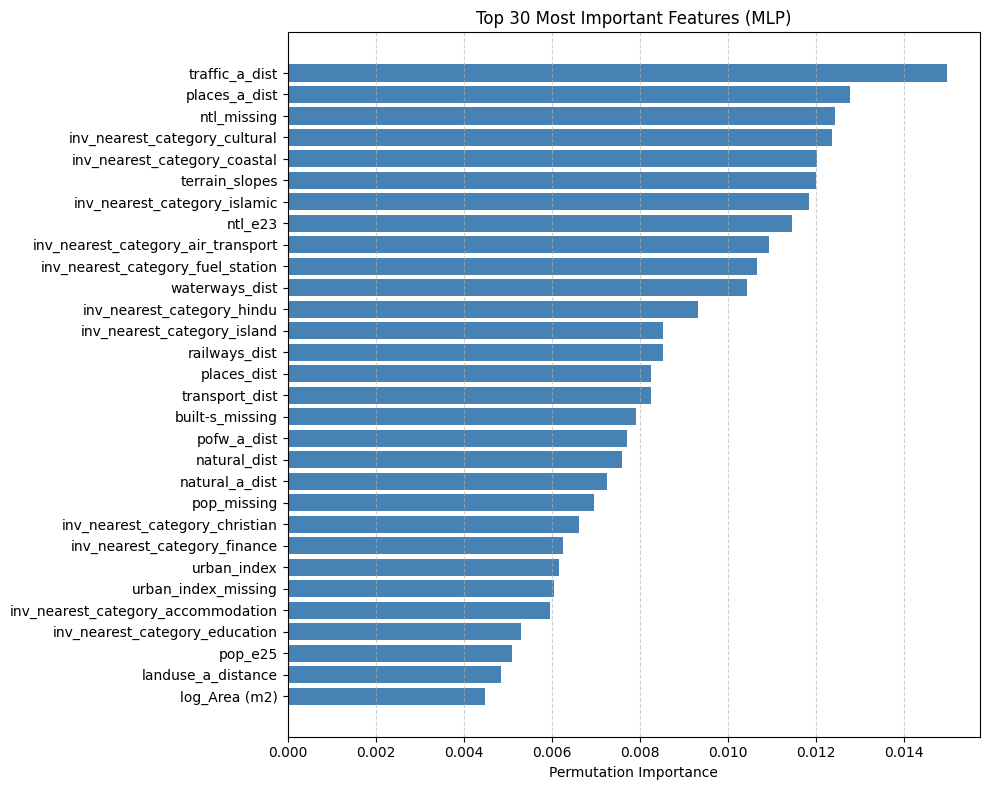

In [7]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Load saved MLP pipeline
saved = joblib.load("D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/mlp_files/final_mlp_model_psedo.joblib")
pipeline = saved['model']
le = saved.get('label_encoder', None)

# --- Use your actual test set (from training split) ---
# X_test, y_test should be the same as used in training evaluation
# For example:
# X_test = ...
# y_test = ...

# Get feature names after preprocessing
preprocessor = pipeline.named_steps['preprocessor']
num_features = preprocessor.transformers_[0][2]  # numeric
cat_pipeline = preprocessor.transformers_[1][1]
cat_features_raw = preprocessor.transformers_[1][2]
onehot = cat_pipeline.named_steps['onehot']
cat_feature_names = onehot.get_feature_names_out(cat_features_raw)
feature_names = np.array(list(num_features) + list(cat_feature_names))

# Compute permutation importance
result = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get top features
top_n = 30
indices = np.argsort(result.importances_mean)[::-1][:top_n]
top_features = feature_names[indices]
top_importances = result.importances_mean[indices]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(top_features[::-1], top_importances[::-1], color='steelblue')
plt.xlabel("Permutation Importance")
plt.title(f"Top {top_n} Most Important Features (MLP)")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [2]:
import fiona
import pandas as pd

rf_path = r"D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/mlp_files/MLP_final_predictions.gpkg"
pred_col = "Predicted"  

# Open the file without geometry
with fiona.open(rf_path, layer=0) as src:
    # Extract only the prediction column from attributes
    pred_values = [feat["properties"][pred_col] for feat in src]

# Create dataframe from predictions
df = pd.DataFrame(pred_values, columns=[pred_col])

# Count & percentage
counts = df[pred_col].value_counts()
total = len(df)
percent = (counts / total * 100).round(2)

# Summary table
summary = counts.to_frame(name="Count")
summary["Percentage"] = percent

print("\n📊 MLP Prediction Summary:")
print(summary)
print("\n🏠 Total Buildings:", total)
print(f"Residential: {counts.get('residential', 0)} ({percent.get('residential', 0)}%)")
print(f"Non-residential: {counts.get('non_residential', 0)} ({percent.get('non_residential', 0)}%)")

if counts.get('non_residential', 0) != 0:
    ratio = counts.get('residential', 0) / counts.get('non_residential', 0)
    print(f"\n📈 Residential to Non-residential Ratio: {ratio:.2f} : 1")



📊 MLP Prediction Summary:
                   Count  Percentage
Predicted                           
residential      8053240       73.26
non_residential  2940170       26.74

🏠 Total Buildings: 10993410
Residential: 8053240 (73.26%)
Non-residential: 2940170 (26.74%)

📈 Residential to Non-residential Ratio: 2.74 : 1
